# Importing dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

# Reading dataset

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep= ';')
num_col = len(list(df.columns))
pd.set_option('display.max_columns', num_col*3)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Label Encoding the categorical Features

In [3]:
col = ['job', 'contact', 'marital', 'day_of_week', 'default','education', 'default', 'housing', 'loan', 'poutcome', 'month', 'y']
for c in col:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df[c])
    df[c] = label_encoder.transform(df[c])

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


# Feature Selection

In [5]:
labels = df.y
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(df.drop(['y'], axis = 1))
#Using Chi-Squared Test
threshold = 1e-50
pvalues = chi2(features, labels)[1]
print("Selected Features with pvalues grater than threshold : ")
for i in range(len(pvalues)):
    if pvalues[i] > threshold:
        print(df.columns[i])
features = pd.DataFrame(SelectKBest(chi2, k=14).fit_transform(features, labels))

Selected Features with pvalues grater than threshold : 
age
job
marital
education
default
housing
loan
month
day_of_week
campaign
pdays
poutcome
cons.price.idx
cons.conf.idx


# Splitting Dataset into Train and Test Set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features.sample(500), 
    labels.sample(500), 
    test_size=0.2, 
    random_state=1)

# Applying Double Cross Validation on Parametrized method with varying parameters

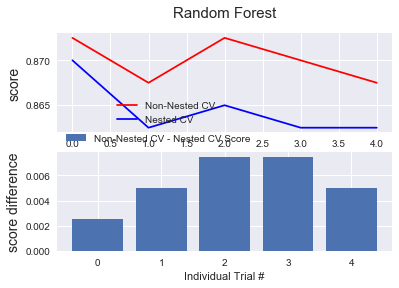

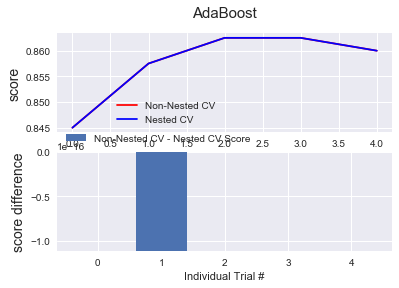

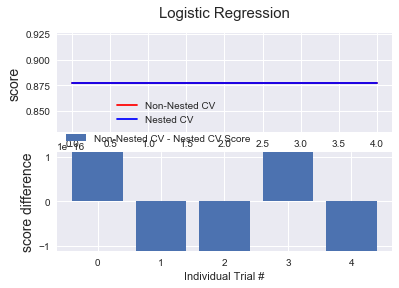

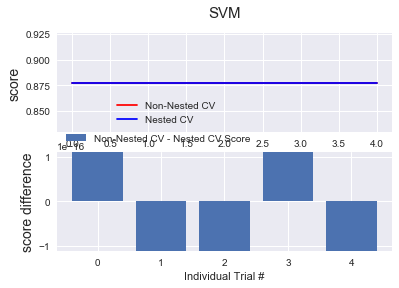

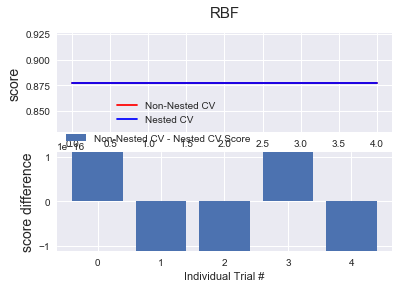

In [7]:
training = pd.DataFrame(columns = ["Classifier", "Mean Accuracy", "Variance in Accuracy"])
testing = pd.DataFrame(columns = ["Classifier", "Mean Accuracy", "Variance in Accuracy"])
accuracy = []
names = [ "Random Forest", "AdaBoost", "Logistic Regression", "SVM", "RBF"]
classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(learning_rate= 2),
    LogisticRegression(penalty ='l2', solver ='liblinear'),
    SVC(gamma=2, C=1, kernel = 'linear'),
    SVC(gamma=2, C=1, kernel = 'rbf')
    ]

NUM_TRIALS = 5
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

p_grid = {"Random Forest": {'n_estimators': [10, 100], 'max_features': ['sqrt', 'log2']},
          "AdaBoost": {"learning_rate": [0.3, 1, 3]},
          "Logistic Regression": {"max_iter": [10, 100, 1000]},
          "SVM": {"gamma":[0.1,1], "C":[1, 10]},
          "RBF": {"gamma":[0.1,1], "C":[1, 10]}
         }

# Loop for each trial
for name, classifier in zip(names, classifiers):
    scores = []
    # double cross-val
    non_nested = np.zeros(NUM_TRIALS)
    nested = np.zeros(NUM_TRIALS)
    for i in range(NUM_TRIALS):
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=classifier, param_grid = p_grid[name], cv=inner_cv, n_jobs = -1)
        clf.fit(X_train, y_train)
        non_nested[i] = clf.best_score_

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X= X_train, y= y_train, cv=outer_cv)
        nested[i] = nested_score.mean()
        scores.append(clf.score(X_test, y_test))
    
    mean_train = nested.mean()
    var_train = nested.var()
    training.loc[-1] = [name, mean_train, var_train]
    training.index = training.index + 1
    training = training.sort_index()
    
    mean_test = np.mean(scores)
    var_test = np.var(scores)
    testing.loc[-1] = [name, mean_test, var_test]
    testing.index = testing.index + 1
    testing = testing.sort_index()

    score_difference = non_nested - nested

    plt.figure()
    plt.subplot(211)
    non_nested_scores_line, = plt.plot(non_nested, color='r')
    nested_line, = plt.plot(nested, color='b')
    plt.ylabel("score", fontsize="14")
    plt.legend([non_nested_scores_line, nested_line],
               ["Non-Nested CV", "Nested CV"],
               bbox_to_anchor=(0, .4, .5, 0))
    plt.title(name, x=.5, y=1.1, fontsize="15")

    # Plot bar chart of the difference.
    plt.subplot(212)
    difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
    plt.xlabel("Individual Trial #")
    plt.legend([difference_plot],
               ["Non-Nested CV - Nested CV Score"],
               bbox_to_anchor=(0, 1, .8, 0))
    plt.ylabel("score difference", fontsize="14")

    plt.show()
    accuracy.append(pd.DataFrame({'Validation Accuracy':nested, 'Training Accuracy':non_nested, 'Test Accuracy':scores}))

# Validation Set Accuracy

In [8]:
training

,Classifier,Mean Accuracy,Variance in Accuracy
0,RBF,0.8775,1.972152e-32
1,SVM,0.8775,1.972152e-32
2,Logistic Regression,0.8775,1.972152e-32
3,AdaBoost,0.8575,4.250000e-05
4,Random Forest,0.8645,8.500000e-06


# Test Set Accuracy

In [9]:
testing

,Classifier,Mean Accuracy,Variance in Accuracy
0,RBF,0.890,0.000000
1,SVM,0.890,0.000000
2,Logistic Regression,0.890,0.000000
3,AdaBoost,0.890,0.000000
4,Random Forest,0.882,0.000176


# Box Plots

# Random Forest Classifier

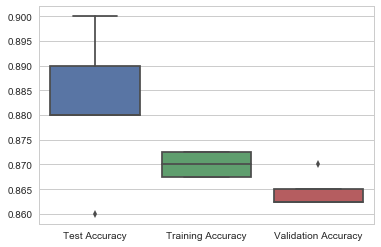

In [10]:
sns.set_style("whitegrid")
#Random Forest Classifier
ax = sns.boxplot(data = accuracy[0])

# Adaboost

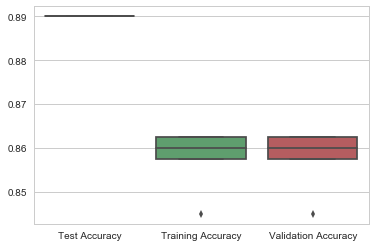

In [11]:
#Adaboost
ax = sns.boxplot(data = accuracy[1])

# Logistic Regression

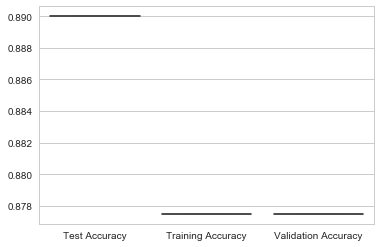

In [12]:
#Logistic Regression
sns.boxplot(data = accuracy[2])

# Linear SVM

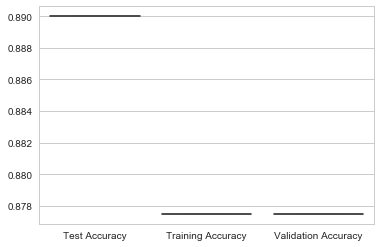

In [13]:
#Linear SVM
sns.boxplot(data = accuracy[3])

# Radial Basis Function

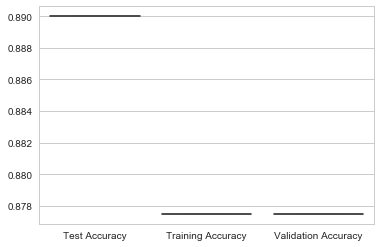

In [14]:
#Radial Basis Function
sns.boxplot(data = accuracy[4])